In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

In [10]:
data = pd.read_csv("./../data/wine.data", header=None)
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_train_std)

In [13]:
# Для каждого класса вычислить d-мерный вектор средних значений
np.set_printoptions(precision=4)
mean_vectors = []

for label in range(1, 4):
    mean_vectors.append(np.mean(X_train_std[y_train == label], axis=0))
    print("Mean Value %s: %s\n" % (label, mean_vectors[label-1]))

Mean Value 1: [ 0.9585 -0.322   0.3219 -0.7607  0.4346  0.8574  0.9809 -0.4969  0.4261
  0.2418  0.4251  0.7139  1.1879]

Mean Value 2: [-0.8829 -0.3073 -0.4875  0.2536 -0.323  -0.0632  0.0417 -0.0784  0.185
 -0.8575  0.4598  0.2946 -0.7075]

Mean Value 3: [ 0.1468  0.8657  0.3387  0.5609 -0.0506 -0.9695 -1.282   0.7362 -0.8096
  0.9987 -1.2249 -1.3334 -0.4039]



In [17]:
# Используя векторы средних значений вычислить матрицу рассеяния Sw
d = 13
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vectors):
    class_scatter = np.zeros((d, d))

    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)

    S_W += class_scatter

print(f'Within-class scatter matrix: {S_W.shape[0]} x {S_W.shape[1]} Within-class scatter matrix: 13x13')

Within-class scatter matrix: 13 x 13 Within-class scatter matrix: 13x13


In [19]:
# Второй способ
d = 13 # number of features
S_W = np.zeros((d, d))

for label,mv in zip(range(1, 4), mean_vectors):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

print(f'Scaled within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


In [42]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

In [36]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vectors):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [37]:
# Вычислите собственные вектора и значения используя S_w и S_b
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [38]:
# Остортируйте собственные значения в порядке убывания
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

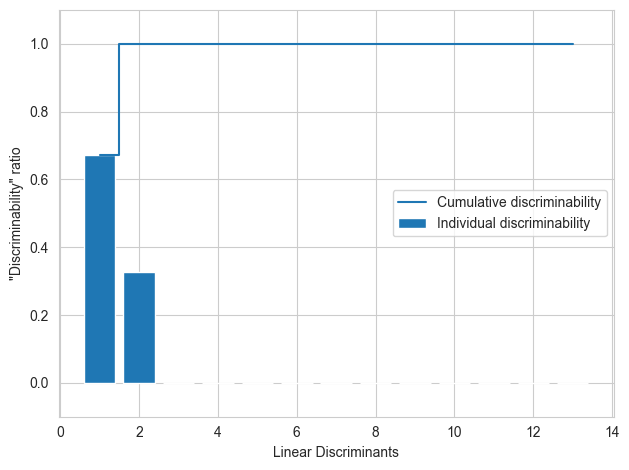

In [39]:
# Постройте график различимости
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, align='center', label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative discriminability')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [40]:
# Сделайте выбор в пользу количества дискриминант и постройте W
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))

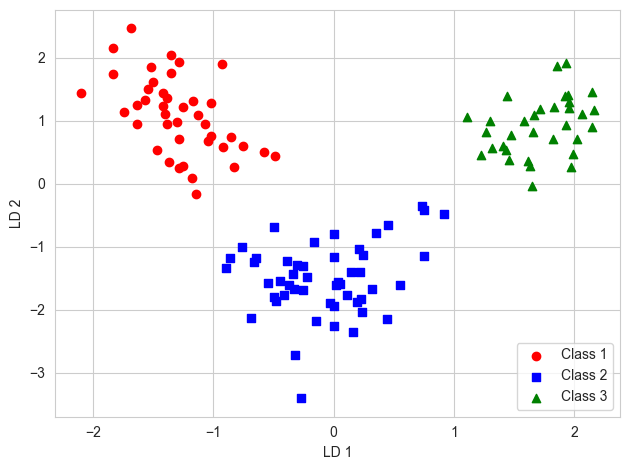

In [41]:
# Видоизмените пространство исходных данных и визуализируйте
X_train_lda = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1] * (-1), c=c, label= f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()